# 2次元場PDE - 応用編 - 

In [2]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from scipy.signal import convolve2d
from scipy.integrate import solve_ivp

## TDGLのスピノーダル分解

TDGLは時間依存ギンツブルグランダウの略です．オーダーパラメータ$\psi$の保存則が，
$$
    \psi = (\partial_{xx}+\partial_{yy})\mu
$$
であり，$\mu$はGL-Wilsonハミルトニアンの$\psi$微分であって，
$$
    \mu = - \psi + \psi^3 - (\partial_{xx}+\partial_{yy})\psi
$$
定数を除いて書けるとします．　相分離によるスピノーダル分解を見てみましょう．

In [2]:
# parameter
N = Nx = Ny = 40
Δ = Δx = Δy = 1.0
D = (1.0/Δ**2)
A = np.array([[0.0,   D,0.0],
              [D  ,-4*D,  D],
              [0.0,   D,0.0],])
# init
Ψ = 2.0*(np.random.rand(N,N)-0.5)*0.1
Ψ -= Ψ.mean()
init = Ψ.flatten()
# time
t_span=[0.0,20.0]
t_eval=np.linspace(*t_span,3)
# ODEs
def ODEs(t,Ψ):
    Ψ = Ψ.reshape(N,N)
    μ = - Ψ + Ψ**3 - convolve2d(Ψ,A,'same','wrap')
    dΨ = convolve2d(μ,A,'same','wrap')
    return dΨ.flatten()
#
sol = solve_ivp(ODEs,t_span,init,'RK23',t_eval)

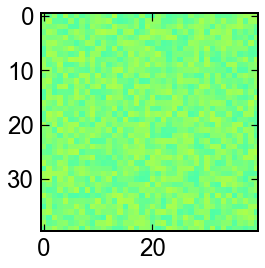

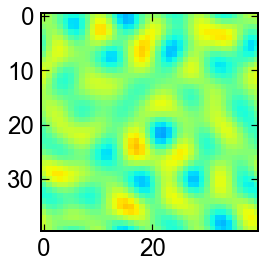

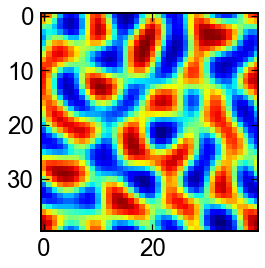

In [3]:
vmax,vmin = sol.y.max(),sol.y.min()
for Ψ in sol.y.T:
    Ψ = Ψ.reshape(N,N)
    fig,ax = plt.subplots(figsize=(4,4))
#     ax.imshow(Ψ,cmap='jet')
    ax.imshow(Ψ,cmap='jet',vmax=vmax,vmin=vmin)
    plt.show()

## 非圧縮性Navie-Stokes方程式

2次元に適用できる流れ関数渦度法を用いて，Navie-Stokes方程式の数値解の例を見てみましょう．
$$
    \partial_{t}\omega + \partial_y \phi \partial_x\omega_x- \partial_x\phi\partial_y\omega
    =\nu(\partial_{xx}+\partial_{yy})\omega
$$
$$
    (\partial_{xx}+\partial_{yy})\phi=-\omega
$$

参考資料はこちら．
https://index-press.co.jp/books/digest/ceslib2.pdf

In [3]:
# parameter
N = Nx = Ny = 50
Δ = Δx = Δy = 1.0
D = (1.0/Δ**2)
A = np.array([[0.0,   D,0.0],
              [D  ,-4*D,  D],
              [0.0,   D,0.0],])
s = N
C = np.diag(-4.0*np.ones(s*s  )/Δ**2,k= 0) +\
    np.diag(+1.0*np.ones(s*s-1)/Δ**2,k=-1) +\
    np.diag(+1.0*np.ones(s*s-1)/Δ**2,k=+1) +\
    np.diag(+1.0*np.ones(s*s-s)/Δ**2,k=-s) +\
    np.diag(+1.0*np.ones(s*s-s)/Δ**2,k=+s) 
#
Re=1.
# init
ω = np.zeros((N,N))
ω[N//4,N//4]    =1.0 # vor1
ω[3*N//4,3*N//4]=1.0 # vor2
init = ω.flatten()
# time
t_span=[0.0,80.0]
t_eval=np.linspace(*t_span,5)
# ODEs
def ODEs(t,ω):
    ψ = np.linalg.solve(C,-ω).reshape(N,N)
    ω = ω.reshape(N,N)
    dω = np.zeros((N,N))
    dω[1:-1,1:-1] = 0.25/Δ**2*(ψ[2:]-ψ[:-2])[:,1:-1]*(ω[:,2:]-ω[:,:-2])[1:-1,:] + \
        (1.0/Re)*(np.diff(ω,2,axis=0)[:,1:-1]/Δ**2+np.diff(ω,2,axis=1)[1:-1,:]/Δ**2)
    return dω.flatten()
#
sol = solve_ivp(ODEs,t_span,init,'RK23',t_eval)

初期状態で与えた渦が合体して一つの大きな渦になっていく

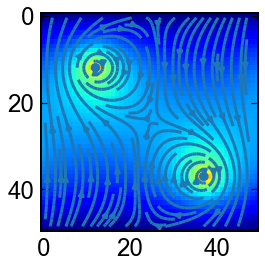

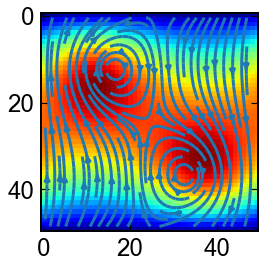

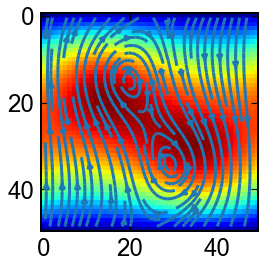

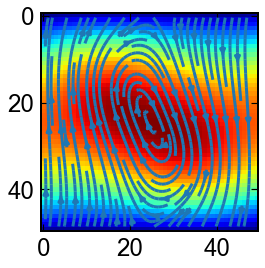

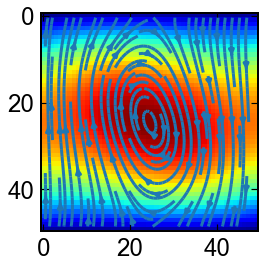

In [4]:
x = np.linspace(0.,N-1,N)
x = 0.5*(x[1:]+x[:-1])
xx,yy = np.meshgrid(x,x)
for ω in sol.y.T:
    ψ = np.linalg.solve(C,-ω).reshape(N,N)
    vx,vy = np.diff(ψ,1,1)/Δ, -np.diff(ψ,1,0)/Δ
    fig,ax = plt.subplots(figsize=(4,4))
    ax.streamplot(xx,yy,0.5*(vx[1:,:]+vx[:-1,:]).T,0.5*(vy[:,1:]+vy[:,:-1]).T,cmap='jet')
    ax.imshow(np.abs(ψ),cmap='jet')
    plt.show()